In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, copy
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from scipy.stats import norm

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_context("notebook")
sns.set_theme(style="ticks", palette="muted")
%matplotlib inline

/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting'

Notebook is in: /home/sulab/tRNA-charge-seq/projects/masked-align_analysis
Repo is in: /home/sulab/tRNA-charge-seq


# Analysis of the effect of alignment masking and barcode use
In the following, we will look at the differences between using masked or unmasked alignment to map the tRNA-charge sequencing data.
We will see that the charge is mostly unaffected by alignment masking and for most transcripts/codons the relative expression is also mostly unaffected.
However, the relative expression of a few transcripts/codons are changed massively by alignment masking, with the biggest changes seen in a few Ser/Pro codons also observed by Behrens et al. 2021.

The data used here is a set of 9 samples made with the same RNA source using each of the 9 different barcoded adapters.
The RNA source is partially deacylated to give a good spread of tRNA charge accross different transcripts.


### Prepping the data

In [3]:
# Merge, annotate and filter data:
def prep_charge_df(plot_obj, sample_df, min_count=1000, agg='tr'):
    # Add E.coli control RPM to sample level information:
    ectr = plot_obj.charge_filt[agg][plot_obj.charge_filt[agg]['Ecoli_ctr']].copy()
    sample_df = ectr.loc[:, ['sample_name_unique', 'RPM']].merge(sample_df, on='sample_name_unique')
    sample_df = sample_df.rename(columns={'RPM': 'RPM_Ectr'}, errors='ignore')

    # Extract dataframe with charge and add sample information:
    charge_df = sample_df.loc[:, ['sample_name_unique', 'hue_value', 'hue_order', 'RPM_Ectr']].merge(plot_obj.charge_filt[agg], on='sample_name_unique')

    if agg == 'tr':
        charge_df['tRNA_anno_short'] = ['mito-'+an if mc else an for an, mc in zip(charge_df['tRNA_anno_short'], charge_df['mito_codon'])]
    elif agg == 'codon':
        charge_df['AA_codon'] = ['mito-'+an if mc else an for an, mc in zip(charge_df['AA_codon'], charge_df['mito_codon'])]

    # Enforce minimum read count:
    # For each annotation, find samples
    # that have above the minimum count:
    if agg == 'tr':
        anno_col = 'tRNA_annotation'
    elif agg == 'aa':
        anno_col = 'amino_acid'
    else:
        anno_col = 'AA_codon'
        
    tann2snu = dict()
    for snu, tann, ectr, cnt in zip(charge_df['sample_name_unique'], \
                                    charge_df[anno_col], \
                                    charge_df['Ecoli_ctr'], \
                                    charge_df['count']):
        if ectr or cnt <= min_count:
            continue

        if tann in tann2snu:
            tann2snu[tann].add(snu)
        else:
            tann2snu[tann] = set()
            tann2snu[tann].add(snu)

    # Filter tRNA annotation based on
    # all samples having above the minimum count:
    all_snu = set(charge_df['sample_name_unique'])
    tann_sele = set()
    for tann in tann2snu:
        if tann2snu[tann] == all_snu:
            tann_sele.add(tann)
    mask = charge_df[anno_col].isin(tann_sele)
    filt_df = charge_df[mask].copy()
    filt_df['RPM_norm'] = filt_df['RPM'] / filt_df['RPM_Ectr']
    
    return(filt_df)

In [4]:
# Read the data:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Isolate the barcode test samples:
mask = (sample_df['plot_group'] == 'Barcode test')
sample_df = sample_df[mask].reset_index(drop=True).copy()

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='data/stats_collection/ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
plot_obj.get_charge_df()
tr_df = prep_charge_df(plot_obj, sample_df, min_count=1, agg='tr')
tr_df['Masked'] = False
cd_df = prep_charge_df(plot_obj, sample_df, min_count=1, agg='codon')
cd_df['Masked'] = False

# Get charge dataframe for aggregated stats (masked):
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='data/stats_collection_masked/ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
plot_obj.get_charge_df()
tr_df_masked = prep_charge_df(plot_obj, sample_df, min_count=1, agg='tr')
tr_df_masked['Masked'] = True
cd_df_masked = prep_charge_df(plot_obj, sample_df, min_count=1, agg='codon')
cd_df_masked['Masked'] = True

# Merge the two dataframes:
tr_dfm = tr_df.merge(tr_df_masked, on=['sample_name_unique', 'tRNA_anno_short'], suffixes=(None, '_masked'))
tr_dfc = pd.concat([tr_df, tr_df_masked])
cd_dfm = cd_df.merge(cd_df_masked, on=['sample_name_unique', 'AA_codon'], suffixes=(None, '_masked'))
cd_dfc = pd.concat([cd_df, cd_df_masked])

# Get dataframes aggregated over the replicates:
tr_dfm_agg = tr_dfm.groupby('tRNA_anno_short').agg(RPM_mean=('RPM', 'mean'), \
                                                   RPM_median=('RPM', 'median'), \
                                                   RPM_masked_mean=('RPM_masked', 'mean'), \
                                                   RPM_masked_median=('RPM_masked', 'median'), \
                                                   RPM_std=('RPM', 'std'), \
                                                   RPM_masked_std=('RPM_masked', 'std'), \
                                                   charge_mean=('charge', 'mean'), \
                                                   charge_median=('charge', 'median'), \
                                                   charge_masked_mean=('charge_masked', 'mean'), \
                                                   charge_masked_median=('charge_masked', 'median'), \
                                                   charge_std=('charge', 'std'), \
                                                   charge_masked_std=('charge_masked', 'std')).reset_index()

cd_dfm_agg = cd_dfm.groupby('AA_codon').agg(RPM_mean=('RPM', 'mean'), \
                                            RPM_median=('RPM', 'median'), \
                                            RPM_masked_mean=('RPM_masked', 'mean'), \
                                            RPM_masked_median=('RPM_masked', 'median'), \
                                            RPM_std=('RPM', 'std'), \
                                            RPM_masked_std=('RPM_masked', 'std'), \
                                            charge_mean=('charge', 'mean'), \
                                            charge_median=('charge', 'median'), \
                                            charge_masked_mean=('charge_masked', 'mean'), \
                                            charge_masked_median=('charge_masked', 'median'), \
                                            charge_std=('charge', 'std'), \
                                            charge_masked_std=('charge_masked', 'std')).reset_index()

Folder exists and overwrite set to false... Doing nothing.
Folder exists and overwrite set to false... Doing nothing.


### Plotting the differences

Below we will plot the differences in RPM and charge measurements.

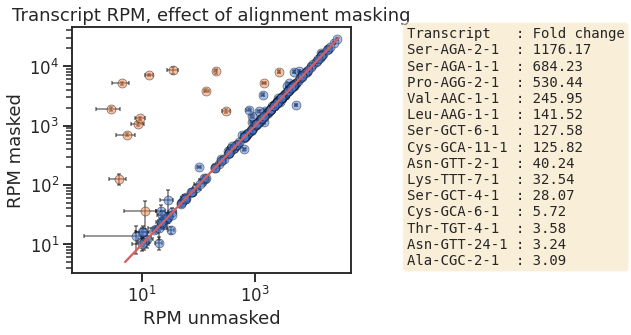

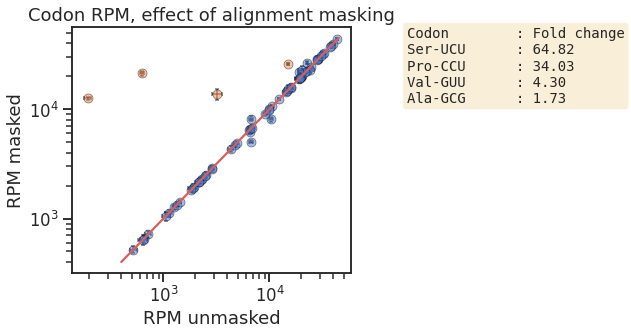

In [5]:
### RPM differences ###
with PdfPages('data/plotting/RPM_maskVSunmasked.pdf') as pp:
    # Plot the RPM repeatability per transcript
    # comparing masked vs. non-masked alignment.

    # Sort out the transcripts with high fold change:
    fold_mask = ((tr_dfm_agg['RPM_mean'] / tr_dfm_agg['RPM_masked_mean']) > 3) | \
                    ((tr_dfm_agg['RPM_masked_mean'] / tr_dfm_agg['RPM_mean']) > 3)
    min_mask = (tr_dfm_agg['RPM_mean'] > 10) | (tr_dfm_agg['RPM_masked_mean'] > 10)
    tr_dfm_agg['RPM_maskedVSunmasked'] = (tr_dfm_agg['RPM_masked_mean'] / tr_dfm_agg['RPM_mean'])
    fold_anno = tr_dfm_agg.loc[fold_mask&min_mask, ['tRNA_anno_short', 'RPM_maskedVSunmasked']].values

    # Plot:
    fig = plt.figure(figsize=(9, 5))
    gs = fig.add_gridspec(1, 5)
    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[0, 3:5])
    ax2.axis('off') # for textbox

    # Scatter for small fold change:
    g1 = sns.scatterplot(ax=ax1, data=tr_dfm_agg[(~fold_mask)&min_mask], x='RPM_mean', y='RPM_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('Transcript RPM, effect of alignment masking')
    g1.set(xlabel='RPM unmasked', ylabel='RPM masked')
    g1.set_yscale('log', base=10)
    g1.set_xscale('log', base=10)
    # Scatter for large fold change:
    g2 = sns.scatterplot(ax=ax1, data=tr_dfm_agg[fold_mask&min_mask], x='RPM_mean', y='RPM_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)

    # Errorbar for all datapoints:
    ax1.errorbar(tr_dfm_agg[min_mask]['RPM_mean'].values, \
                 tr_dfm_agg[min_mask]['RPM_masked_mean'].values, \
                 xerr=tr_dfm_agg[min_mask]['RPM_std'].values, \
                 yerr=tr_dfm_agg[min_mask]['RPM_masked_std'].values, \
                 fmt='none', capsize=2, zorder=1, \
                 ecolor='black', elinewidth=2, capthick=2, alpha=0.4)
    ax1.plot([5, 30000], [5, 30000], c='r', zorder=10)

    # Make textbox for transcripts 
    # with >100% fold change:
    txt_list = list()
    # print('{:<13}: {}'.format(*['Transcript', 'Fold change']))
    txt_list.append('{:<13}: {}'.format(*['Transcript', 'Fold change']))
    for tr_tup in sorted(fold_anno, key=lambda x: x[1], reverse=True):
        # print('{:<13}: {:.2f}'.format(*tr_tup))
        txt_list.append('{:<13}: {:.2f}'.format(*tr_tup))
    anno_str = '\n'.join(txt_list)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.2, 1, anno_str, transform=ax2.transAxes, fontsize=14,
             verticalalignment='top', bbox=props, fontfamily='monospace')

    fig.tight_layout()
    # fig.savefig('data/plotting/tr_RPM_maskVSunmasked.pdf', bbox_inches='tight')
    pp.savefig(fig, bbox_inches='tight')
    
    
    # Plot the RPM repeatability per codon
    # comparing masked vs. non-masked alignment.

    # Sort out the codons with high fold change:
    fold_mask = ((cd_dfm_agg['RPM_mean'] / cd_dfm_agg['RPM_masked_mean']) > 1.5) | \
                    ((cd_dfm_agg['RPM_masked_mean'] / cd_dfm_agg['RPM_mean']) > 1.5)
    min_mask = (cd_dfm_agg['RPM_mean'] > 100) | (cd_dfm_agg['RPM_masked_mean'] > 100)
    cd_dfm_agg['RPM_maskedVSunmasked'] = (cd_dfm_agg['RPM_masked_mean'] / cd_dfm_agg['RPM_mean'])
    fold_anno = cd_dfm_agg.loc[fold_mask&min_mask, ['AA_codon', 'RPM_maskedVSunmasked']].values

    # Plot:
    fig = plt.figure(figsize=(9, 5))
    gs = fig.add_gridspec(1, 5)
    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[0, 3:5])
    ax2.axis('off') # for textbox

    # Scatter for small fold change:
    g1 = sns.scatterplot(ax=ax1, data=cd_dfm_agg[(~fold_mask)&min_mask], x='RPM_mean', y='RPM_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('Codon RPM, effect of alignment masking')
    g1.set(xlabel='RPM unmasked', ylabel='RPM masked')
    g1.set_yscale('log', base=10)
    g1.set_xscale('log', base=10)
    # Scatter for large fold change:
    g2 = sns.scatterplot(ax=ax1, data=cd_dfm_agg[fold_mask&min_mask], x='RPM_mean', y='RPM_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)

    # Errorbar for all datapoints:
    ax1.errorbar(cd_dfm_agg[min_mask]['RPM_mean'].values, \
                 cd_dfm_agg[min_mask]['RPM_masked_mean'].values, \
                 xerr=cd_dfm_agg[min_mask]['RPM_std'].values, \
                 yerr=cd_dfm_agg[min_mask]['RPM_masked_std'].values, \
                 fmt='none', capsize=2, zorder=1, \
                 ecolor='black', elinewidth=2, capthick=2, alpha=0.4)
    ax1.plot([400, 45000], [400, 45000], c='r', zorder=10)

    # Make textbox for codons 
    # with >50% fold change:
    txt_list = list()
    # print('{:<13}: {}'.format(*['Transcript', 'Fold change']))
    txt_list.append('{:<13}: {}'.format(*['Codon', 'Fold change']))
    for cd_tup in sorted(fold_anno, key=lambda x: x[1], reverse=True):
        # print('{:<13}: {:.2f}'.format(*cd_tup))
        txt_list.append('{:<13}: {:.2f}'.format(*cd_tup))
    anno_str = '\n'.join(txt_list)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.2, 1, anno_str, transform=ax2.transAxes, fontsize=14,
             verticalalignment='top', bbox=props, fontfamily='monospace')

    fig.tight_layout()
    #fig.savefig('data/plotting/cd_RPM_maskVSunmasked.pdf', bbox_inches='tight')
    pp.savefig(fig, bbox_inches='tight')

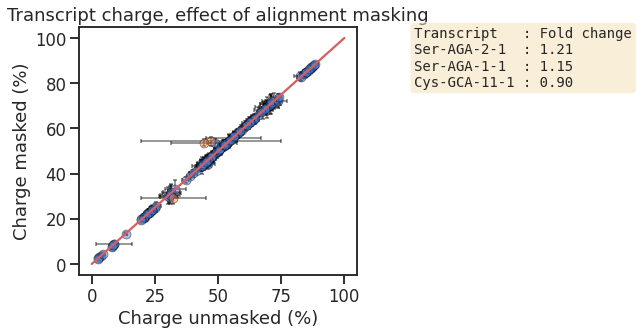

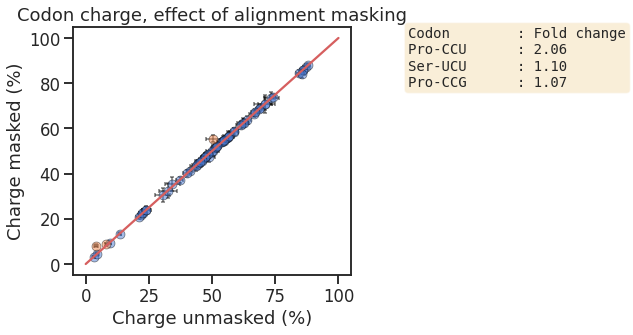

In [6]:
### Charge differences ###
with PdfPages('data/plotting/charge_maskVSunmasked.pdf') as pp:
    # Plot the charge repeatability per transcript
    # comparing masked vs. non-masked alignment.

    # Sort out the transcripts with high fold change:
    fold_mask = ((tr_dfm_agg['charge_mean'] / tr_dfm_agg['charge_masked_mean']) > 1.1) | \
                    ((tr_dfm_agg['charge_masked_mean'] / tr_dfm_agg['charge_mean']) > 1.1)
    min_mask = (tr_dfm_agg['RPM_mean'] > 1000) | (tr_dfm_agg['RPM_masked_mean'] > 1000)
    tr_dfm_agg['charge_maskedVSunmasked'] = (tr_dfm_agg['charge_masked_mean'] / tr_dfm_agg['charge_mean'])
    fold_anno = tr_dfm_agg.loc[fold_mask&min_mask, ['tRNA_anno_short', 'charge_maskedVSunmasked']].values

    # Plot:
    fig = plt.figure(figsize=(9, 5))
    gs = fig.add_gridspec(1, 5)
    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[0, 3:5])
    ax2.axis('off') # for textbox

    # Scatter for small fold change:
    g1 = sns.scatterplot(ax=ax1, data=tr_dfm_agg[(~fold_mask)&min_mask], x='charge_mean', \
                         y='charge_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('Transcript charge, effect of alignment masking')
    g1.set(xlabel='Charge unmasked (%)', ylabel='Charge masked (%)')
    # Scatter for large fold change:
    g2 = sns.scatterplot(ax=ax1, data=tr_dfm_agg[fold_mask&min_mask], x='charge_mean', y='charge_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)

    # Errorbar for all datapoints:
    ax1.errorbar(tr_dfm_agg[min_mask]['charge_mean'].values, \
                 tr_dfm_agg[min_mask]['charge_masked_mean'].values, \
                 xerr=tr_dfm_agg[min_mask]['charge_std'].values, \
                 yerr=tr_dfm_agg[min_mask]['charge_masked_std'].values, \
                 fmt='none', capsize=2, zorder=1, \
                 ecolor='black', elinewidth=2, capthick=2, alpha=0.4)
    ax1.plot([0, 100], [0, 100], c='r', zorder=10)

    # Make textbox for transcripts 
    # with >10% fold change:
    txt_list = list()
    # print('{:<13}: {}'.format(*['Transcript', 'Fold change']))
    txt_list.append('{:<13}: {}'.format(*['Transcript', 'Fold change']))
    for tr_tup in sorted(fold_anno, key=lambda x: x[1], reverse=True):
        # print('{:<13}: {:.2f}'.format(*tr_tup))
        txt_list.append('{:<13}: {:.2f}'.format(*tr_tup))
    anno_str = '\n'.join(txt_list)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.2, 1, anno_str, transform=ax2.transAxes, fontsize=14,
             verticalalignment='top', bbox=props, fontfamily='monospace')

    fig.tight_layout()
    # fig.savefig('data/plotting/tr_charge_maskVSunmasked.pdf', bbox_inches='tight')
    pp.savefig(fig, bbox_inches='tight')
    
    
    # Plot the charge repeatability per codon
    # comparing masked vs. non-masked alignment.

    # Sort out the codons with high fold change:
    fold_mask = ((cd_dfm_agg['charge_mean'] / cd_dfm_agg['charge_masked_mean']) > 1.05) | \
                    ((cd_dfm_agg['charge_masked_mean'] / cd_dfm_agg['charge_mean']) > 1.05)
    min_mask = (cd_dfm_agg['RPM_mean'] > 1000) | (cd_dfm_agg['RPM_masked_mean'] > 1000)
    cd_dfm_agg['charge_maskedVSunmasked'] = (cd_dfm_agg['charge_masked_mean'] / cd_dfm_agg['charge_mean'])
    fold_anno = cd_dfm_agg.loc[fold_mask&min_mask, ['AA_codon', 'charge_maskedVSunmasked']].values

    # Plot:
    fig = plt.figure(figsize=(9, 5))
    gs = fig.add_gridspec(1, 5)
    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[0, 3:5])
    ax2.axis('off') # for textbox

    # Scatter for small fold change:
    g1 = sns.scatterplot(ax=ax1, data=cd_dfm_agg[(~fold_mask)&min_mask], x='charge_mean', \
                         y='charge_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('Codon charge, effect of alignment masking')
    g1.set(xlabel='Charge unmasked (%)', ylabel='Charge masked (%)')
    # Scatter for large fold change:
    g2 = sns.scatterplot(ax=ax1, data=cd_dfm_agg[fold_mask&min_mask], x='charge_mean', y='charge_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)

    # Errorbar for all datapoints:
    ax1.errorbar(cd_dfm_agg[min_mask]['charge_mean'].values, \
                 cd_dfm_agg[min_mask]['charge_masked_mean'].values, \
                 xerr=cd_dfm_agg[min_mask]['charge_std'].values, \
                 yerr=cd_dfm_agg[min_mask]['charge_masked_std'].values, \
                 fmt='none', capsize=2, zorder=1, \
                 ecolor='black', elinewidth=2, capthick=2, alpha=0.4)
    ax1.plot([0, 100], [0, 100], c='r', zorder=10)

    # Make textbox for codons 
    # with >5% fold change:
    txt_list = list()
    # print('{:<13}: {}'.format(*['Transcript', 'Fold change']))
    txt_list.append('{:<13}: {}'.format(*['Codon', 'Fold change']))
    for cd_tup in sorted(fold_anno, key=lambda x: x[1], reverse=True):
        # print('{:<13}: {:.2f}'.format(*cd_tup))
        txt_list.append('{:<13}: {:.2f}'.format(*cd_tup))
    anno_str = '\n'.join(txt_list)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.2, 1, anno_str, transform=ax2.transAxes, fontsize=14,
             verticalalignment='top', bbox=props, fontfamily='monospace')

    fig.tight_layout()
    #fig.savefig('data/plotting/cd_charge_maskVSunmasked.pdf', bbox_inches='tight')
    pp.savefig(fig, bbox_inches='tight')

The conclusions from the above plots are:
1. Charge measurements are unaffected by alignment masking.
 * With a few exceptional transcripts that also have major RPM change upon alignment masking.
2. Alignment masking substantially increase the RPM values of a handful of transcripts while not substantially decreasing any. Since the sum the RPM values is a constant (1e6) this means that alignment masking does not simply shift all the reads from one transcript to another.
3. For only four codons the RPM values are substantially change upon alignment masking.

The largest increase in RPM values was observed for a Serine and a Proline codon, similar to observations made by Behrens et al. 2021, but also a Valine and an Alanine codon has substantially increased RPM values.
These codons are plotted below.

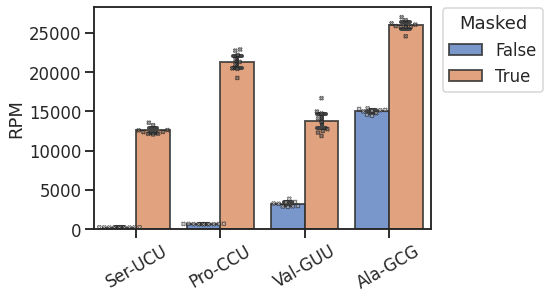

In [7]:
# Sort out the codons with high fold change
# and pick out those with >50% fold change:
fold_mask = ((cd_dfm_agg['RPM_mean'] / cd_dfm_agg['RPM_masked_mean']) > 1.5) | \
                ((cd_dfm_agg['RPM_masked_mean'] / cd_dfm_agg['RPM_mean']) > 1.5)
min_mask = (cd_dfm_agg['RPM_mean'] > 100) | (cd_dfm_agg['RPM_masked_mean'] > 100)
cd_dfm_agg['RPM_maskedVSunmasked'] = (cd_dfm_agg['RPM_masked_mean'] / cd_dfm_agg['RPM_mean'])
fold_anno = cd_dfm_agg.loc[fold_mask&min_mask, ['AA_codon', 'RPM_maskedVSunmasked']].values
anno_order = [t[0] for t in sorted(fold_anno, key=lambda x: x[1], reverse=True)]

# Plot the chosen codons:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))
mask = (cd_dfc['AA_codon'].isin(anno_order))

g1 = sns.barplot(ax=ax1, data=cd_dfc[mask], y='RPM', x='AA_codon', hue='Masked', \
                 order=anno_order, capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                 zorder=1)
g1 = sns.swarmplot(ax=ax1, data=cd_dfc[mask], y='RPM', x='AA_codon', hue='Masked', \
                   dodge=True, order=anno_order, \
                   palette='light:grey', alpha=0.6, edgecolor='black', linewidth=0.8, \
                   size=4, marker="X", legend=False, \
                   zorder=2)
sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1)
g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
g1.set(xlabel='')
fig.tight_layout()

fig.savefig('data/plotting/Ser-Pro_codons_RPM-change.pdf', bbox_inches='tight')

### Analyzing barcode bias

There is one sample per barcoded adapter and thus we can compare them to detect any single barcode bias i.e. a ligation preference for CC or CCA-ends or certain transcripts.
These samples can also give an estimate of the expected spread of charge/RPM measurements.
We perform the analysis using the deviation from the median and summarize the results accross all the transcripts.

For charge measurements the deviation is reported in *percentage points away from the median*, for instance: charge for transcript X with barcode Y is measured to be 37%, the median charge of transcript X is 40%, the charge deviation is calculated as $37-40 = -3\text{%}$.
For RPM values the deviation is reported in *percent difference relative to the median*, for instance: RPM for transcript X with barcode Y is measured to be 13500, the median RPM of transcript X is 15000, the RPM deviation is calculated as $(13500-15000)/15000*100 = -10\text{%}$.


We start by looking at the charge.

In [8]:
# Calculate the deviation from the median
# for RPM values and charge:
tr_OR_cd = 'tRNA_anno_short'
# tr_OR_cd = 'AA_codon'

cols_sele = [tr_OR_cd, \
             'RPM_masked_mean', 'RPM_masked_median', 'RPM_masked_std', \
             'charge_masked_mean', 'charge_masked_median', 'charge_masked_std']
if tr_OR_cd == 'AA_codon':
    charge_df = cd_dfc[cd_dfc['Masked']].copy()
    charge_df = charge_df.merge(cd_dfm_agg.loc[:, cols_sele], on=tr_OR_cd)
else:
    charge_df = tr_dfc[tr_dfc['Masked']].copy()
    charge_df = charge_df.merge(tr_dfm_agg.loc[:, cols_sele], on=tr_OR_cd)
charge_df['RPM_median_dev'] = charge_df['RPM'] - charge_df['RPM_masked_median']
charge_df['RPM_median_dev_p'] = charge_df['RPM_median_dev'] / charge_df['RPM_masked_median'] * 100
charge_df['charge_median_dev'] = charge_df['charge'] - charge_df['charge_masked_median']
charge_df['charge_median_dev_p'] = charge_df['charge_median_dev'] / charge_df['charge_masked_median'] *100

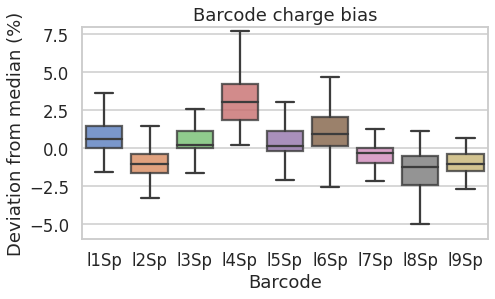

In [9]:
# Plot charge deviation from media broken down by barcode:
min_mask = charge_df['RPM_masked_mean'] > 1000
bc_order = sorted(set(charge_df['barcode']))
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 4.5))
    g1 = sns.boxplot(data=charge_df[min_mask], x='barcode', y='charge_median_dev', \
                     boxprops=dict(alpha=0.8), order=bc_order, fliersize=False)
    g1.set(xlabel='Barcode', ylabel='Deviation from median (%)', ylim=(-6, 8))
    g1.set_title('Barcode charge bias')
    fig.tight_layout()
    fig.savefig('data/plotting/barcode_median-deviation_charge.pdf', bbox_inches='tight')

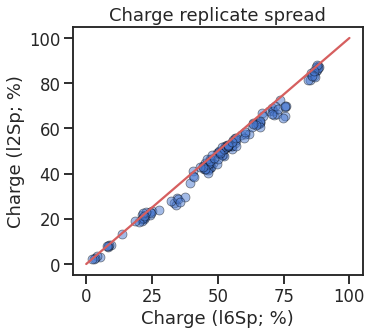

In [11]:
# Draw a random comparison:
roll_1, roll_2 = np.random.randint(1, 10, 2)[:]
while roll_1 == roll_2:
    roll_2 = np.random.randint(1, 10, 1)[0]

# Extract RPM/charge values from two random barcodes:
d1 = charge_df.loc[(charge_df['barcode'] == 'l{}Sp'.format(roll_1)), [tr_OR_cd, 'RPM', 'charge']].copy()
d2 = charge_df.loc[(charge_df['barcode'] == 'l{}Sp'.format(roll_2)), [tr_OR_cd, 'RPM', 'charge']].copy()
d12 = d1.merge(d2, on=tr_OR_cd, suffixes=('_1', '_2'))

# Plot the charge values:
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 5))
min_mask = (d12['RPM_1'] > 1000) | (d12['RPM_2'] > 1000)
g1 = sns.scatterplot(ax=ax1, data=d12[min_mask], x='charge_1', y='charge_2', \
                     zorder=5, alpha=0.5, \
                     edgecolor='black', linewidth=0.7)
g1.set(xlabel='Charge (l{}Sp; %)'.format(roll_1), ylabel='Charge (l{}Sp; %)'.format(roll_2))
g1.set_title('Charge replicate spread')

ax1.plot([0, 100], [0, 100], c='r', zorder=10)
fig.tight_layout()
fig.savefig('data/plotting/charge_repeatability.pdf', bbox_inches='tight')

Interestingly, there is a clear similarlty between the barcode bias found using the replicate samples shown above and that found using charge titration (see the folder `charge_titration` under projects).
Therefore, it is not surprising to see that the l4Sp adapter is giving a systematic overestimate of the charge.

Next, we look at the spread of RPM values broken down by barcodes.

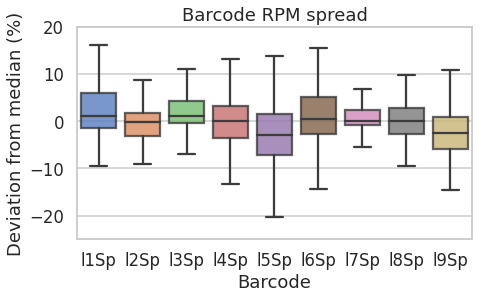

In [13]:
# Plot RPM deviation from media broken down by barcode:
min_mask = charge_df['RPM_masked_mean'] > 1000
bc_order = sorted(set(charge_df['barcode']))
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 4.5))
    g1 = sns.boxplot(data=charge_df[min_mask], x='barcode', y='RPM_median_dev_p', \
                     boxprops=dict(alpha=0.8), order=bc_order, fliersize=False)
    g1.set(xlabel='Barcode', ylabel='Deviation from median (%)', ylim=(-25, 20))
    g1.set_title('Barcode RPM spread')
    fig.tight_layout()
    fig.savefig('data/plotting/barcode_median-deviation_RPM.pdf', bbox_inches='tight')

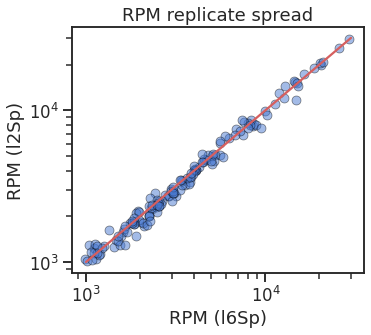

In [14]:
# Use the same barcodes as for the charge plot:
'''
# Draw a random comparison:
roll_1, roll_2 = np.random.randint(1, 10, 2)[:]
while roll_1 == roll_2:
    roll_2 = np.random.randint(1, 10, 1)[0]

# Extract RPM/charge values from two random barcodes:
d1 = charge_df.loc[(charge_df['barcode'] == 'l{}Sp'.format(roll_1)), [tr_OR_cd, 'RPM', 'charge']].copy()
d2 = charge_df.loc[(charge_df['barcode'] == 'l{}Sp'.format(roll_2)), [tr_OR_cd, 'RPM', 'charge']].copy()
d12 = d1.merge(d2, on=tr_OR_cd, suffixes=('_1', '_2'))
'''

# Plot the RPM values:
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 5))
min_mask = (d12['RPM_1'] > 1000) | (d12['RPM_2'] > 1000)
g1 = sns.scatterplot(ax=ax1, data=d12[min_mask], x='RPM_1', y='RPM_2', \
                     zorder=5, alpha=0.5, \
                     edgecolor='black', linewidth=0.7)
g1.set_yscale('log', base=10)
g1.set_xscale('log', base=10)
g1.set(xlabel='RPM (l{}Sp)'.format(roll_1), ylabel='RPM (l{}Sp)'.format(roll_2))
g1.set_title('RPM replicate spread')

ax1.plot([1000, 30000], [1000, 30000], c='r', zorder=10)
fig.tight_layout()
fig.savefig('data/plotting/RPM_repeatability.pdf', bbox_inches='tight')

As RPM values are normalized, the deviation should center around zero regardless of any barcode bias; howerver, the spread of deviations is important for repeatability.
If any one barcode has larger spread than the others it is a bad sign.
As observed above, the RPM values are typically spread with less than +/- 10% of the median and no barcode performs really bad.


### Expected replicate spread

Lastly, we will plot the spread of the nine barcode replicates to get an estimate of replicate precision.
Plotted as probability density in a histogram, the data is fitted by a kernel density function displayed as a blue line and the standard gaussian probability density function with mean and standard deviation from the data is displayed in red.

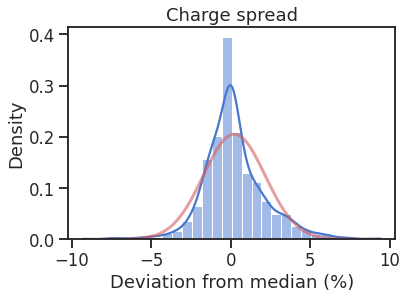

In [15]:
# Extract stats for probability density function:
min_mask = charge_df['RPM_masked_mean'] > 1000
std = np.std(charge_df.loc[min_mask, 'charge_median_dev'].values)
mean = np.mean(charge_df.loc[min_mask, 'charge_median_dev'].values)
hmin = np.min(charge_df.loc[min_mask, 'charge_median_dev'].values)
hmax = np.max(charge_df.loc[min_mask, 'charge_median_dev'].values)

# Plot the charge deviation from the median spread:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4.5))
g1 = sns.histplot(ax=ax1, data=charge_df[min_mask], x='charge_median_dev', \
                  kde=True, bins=30, stat='density')
g1.set(xlabel='Deviation from median (%)')
g1.set_title('Charge spread')

# Overlay the gaussian pdf in addtion
# to the kernel density estimate from Seaborn:
x = np.linspace(hmin, hmax, 1000)
ax1.plot(x, norm.pdf(x, loc=mean, scale=std), 'r-', lw=3, alpha=0.6)

fig.tight_layout()
fig.savefig('data/plotting/median-deviation_charge.pdf', bbox_inches='tight')

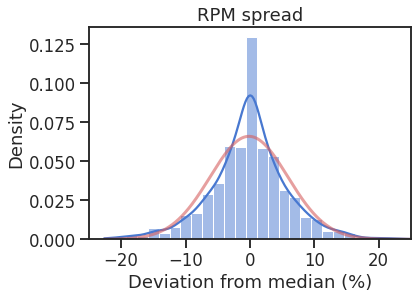

In [16]:
# Extract stats for probability density function:
min_mask = charge_df['RPM_masked_mean'] > 1000
std = np.std(charge_df.loc[min_mask, 'RPM_median_dev_p'].values)
mean = np.mean(charge_df.loc[min_mask, 'RPM_median_dev_p'].values)
hmin = np.min(charge_df.loc[min_mask, 'RPM_median_dev_p'].values)
hmax = np.max(charge_df.loc[min_mask, 'RPM_median_dev_p'].values)

# Plot the RPM deviation from the median spread:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4.5))
g1 = sns.histplot(ax=ax1, data=charge_df[min_mask], x='RPM_median_dev_p', \
                  kde=True, bins=30, stat='density')
g1.set(xlabel='Deviation from median (%)', xlim=(-25, 25))
g1.set_title('RPM spread')

# Overlay the gaussian pdf in addtion
# to the kernel density estimate from Seaborn:
x = np.linspace(hmin, hmax, 1000)
ax1.plot(x, norm.pdf(x, loc=mean, scale=std), 'r-', lw=3, alpha=0.6)

fig.tight_layout()
fig.savefig('data/plotting/median-deviation_RPM.pdf', bbox_inches='tight')

We see from the charge deviation spread that almost all measurements are within +/- 4%, and likely better if adapter l4Sp was excluded.
The RPM values are within +/- 10% of the median.